# APLICAÇÃO DE MACHINE LEARNING E SENSORIAMENTO REMOTO PARA  APRENDIZADO SUPERVISIONADO

Ferdinando Yoshio Agapito Urasaki

yoshio.urasaki@gmail.com

### Este Projeto tem como objetivo apresentar a aplicação do Aprendizado Supervisionado e Algorítmos de Machine Learning na construção de modelos preditivos visando processos semi-automatizados de classificação com utilização de plataforma e softwares livres gratuitos.

---

O Módulo **predict_supervised_learning** foi escrito com o objetivo de viabilizar este processo de automação e é formado por um conjunto de classes e métodos para:

> Executar o **Aprendizado Supervisionado** através de algoritmos de **Machine Learning** com **otimização dos hiperparâmetros** e tratamento dos dados desbalanceados pelo método **RENN - Repeated Edited Nearest Neighbour**, salvando as **métricas** obtidas no formato DataFrame do Pandas e gerando arquivo raster no formato **GeoTiff** resultante da predição do modelo treinado.

Para apresentar de forma prática este Projeto, o arquivo ***predict_supervised_learning.pdf*** descreve os **Materiais** e **Métodos** aplicados no Aprendizado Supervisionado da  Cobertura da Terra utilizando Imagem de Satélite Landsat TM 5, com descrição suscinta da fase de **preparação dos dados** utilizando o **QGIS**, sendo a base teórica para esta **DEMONSTRAÇÃO**.

Para agilizar a execução desta **DEMONSTRAÇÃO** foi gerado um **Recorte** dos dados, com 200 x 200 pixels de dimensão, denominados:

- Classe de Cobertura da Terra: *CLIP_COBERTURA_TERRA.tif*
- Imagem Landsat TM 5: *CLIP_RT_L05_L1TP_219076_20100824_T1_B123457.tif*

podendo-se alterar os valores atribuidos as variáveis **features_path**, **target_path** e **dump_path** para os valores abaixo:

---

| VARIÁVEL      | DATASET COMPLETO                                             | DATASET RECORTE                                         |
| ------------- | ------------------------------------------------------------ | ------------------------------------------------------------ |
| features_path | os.path.join(base_path, 'base', 'RT_L05_L1TP_219076_20100824_T1_B123457.tif') | os.path.join(base_path, 'base', 'CLIP_RT_L05_L1TP_219076_20100824_T1_B123457.tif') |
| target_path   | os.path.join(base_path, 'base', 'COBERTURA_TERRA.tif')       | os.path.join(base_path, 'base', 'CLIP_COBERTURA_TERRA.tif')  |
| dump_path     | os.path.join(base_path, 'dump')                              | os.path.join(base_path, 'dump_demo')                         |


## 1. Definição das variáveis de entrada e saida de dados:

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from predict_supervised_learning import PreProcessingData, CreateModelHyperopt
from predict_supervised_learning import create_raster_predicted

In [2]:
# definição dos caminhos dos arquivos de entrada e saida
base_path = os.getcwd()
features_path = os.path.join(base_path, 'base', 'RT_L05_L1TP_219076_20100824_T1_B123457.tif')
target_path = os.path.join(base_path, 'base', 'COBERTURA_TERRA.tif')
dump_path = os.path.join(base_path, 'dump')

In [3]:
# configuração das variáveis
algorithm_list = ['dummy_classifier', 'gaussian_naive_bayes', 'decision_tree', 'random_forest', 'kneighbors',
                      'logistic_regression', 'linear_support_vector', 'multi_layer_perceptron']

## 2. Compreenção dos Dados

Os dados utilizados para o **Aprendizado Supervisionado** neste Projeto são: 

- **Imagem de Satélite Landsat TM 5** no formato GeoTiff devidamente preparada com seus valores convertidos de Níveis de Cinza para Reflectância do Topo da Atmosfera no QGIS, sendo utilizados como previsores no aprendizado supervisionado.


- **Classes do Mapeamento de Cobertura da Terra**, convertida para o formato GeoTiff, cada pixel do Raster contém os valores dos *id* das Classes de Cobertura da Terra que serão utilizados como rótulo tanto para o treinamento dos modelos quanto para aferição de sua qualidade

## 3. Pré-processamento dos dados

Engobla diversas atividades de pré-processamento envolvendo a integração, preparação, limpeza, tratamento de dados desbalanceados e divisão do dataset em conjunto de treinamento e teste.

In [4]:
# Aplica o Pré-Processamento utilizando as Imagens Landsat como Previsores e as Classes de Cobertura da Terra
# como Rótulo e remove no processo a classe Sombra e Nuvem (id = 7)

class_id = 7
ds = PreProcessingData(features_path, target_path, dump_path, class_id)

In [5]:
# Dataset de Entrada com valores de Reflectância da Imagem de Satélite Landsat TM 5

ds_features = pd.DataFrame(ds.x, columns=['B', 'G', 'R', 'NIR', 'SWIR_1', 'SWIR_2'])
ds_features

,B,G,R,NIR,SWIR_1,SWIR_2
0,0.106083,0.087959,0.080065,0.105709,0.108592,0.095638
1,0.106083,0.084141,0.080065,0.101686,0.108592,0.099357
2,0.104254,0.087959,0.076847,0.125824,0.118952,0.095638
3,0.098769,0.084141,0.076847,0.129847,0.118952,0.084479
4,0.102426,0.084141,0.080065,0.109732,0.108592,0.088199
...,...,...,...,...,...,...
2859995,0.117054,0.110866,0.109028,0.170077,0.168164,0.132834
2859996,0.124368,0.118501,0.118682,0.149962,0.181115,0.162591
2859997,0.138996,0.133772,0.134773,0.174100,0.194065,0.177469
2859998,0.135339,0.126137,0.128337,0.170077,0.181115,0.162591


In [6]:
# Dataset de Saída com valores das Classes do Mapeamento de Cobertura da Terra

ds_target = pd.DataFrame(ds.y, columns=['LC',])
ds_target.T # exibição das linhas com transpor

,0,1,2,3,4,5,6,7,8,9,...,2859990,2859991,2859992,2859993,2859994,2859995,2859996,2859997,2859998,2859999
LC,3,3,3,3,3,3,3,3,3,3,...,2,2,2,2,2,2,4,4,4,4


In [7]:
# Observa-se que as Classes estão desbalanceadas, visto a desproporção entre as distribuições das Classes.

unique, counts = np.unique(ds_target, return_counts=True)

id_classes = pd.Series(unique)
count_classes = pd.Series(counts)
dist_classes = pd.Series(np.round(100*count_classes/count_classes.sum(),2))

frame = [id_classes, dist_classes]
dist_classes = pd.concat(frame, axis=1, keys=['classe', '%'])
dist_classes

,classe,%
0,1,50.28
1,2,17.12
2,3,5.07
3,4,25.99
4,5,0.17
5,6,1.28
6,7,0.09


### 3.1. Limpeza de Dados e Tratamento de Dados Desbalanceados

#### Após a remoção da classe Sombra e Nuvem (id = 7) e aplicação do método Repeated Edited Nearest Neighbor (RENN)

In [8]:
# Dataset de Entrada RENN com valores de Reflectância da Imagem de Satélite Landsat TM 5

ds_features_renn = pd.DataFrame(ds.x_renn, columns=['B', 'G', 'R', 'NIR', 'SWIR_1', 'SWIR_2'])
ds_features_renn

,B,G,R,NIR,SWIR_1,SWIR_2
0,0.095112,0.080323,0.063974,0.198238,0.142263,0.069600
1,0.095112,0.080323,0.060756,0.226399,0.137083,0.073320
2,0.091455,0.076505,0.060756,0.218353,0.137083,0.065881
3,0.095112,0.084141,0.063974,0.234445,0.157804,0.069600
4,0.093283,0.072687,0.057538,0.198238,0.118952,0.054722
...,...,...,...,...,...,...
1520413,0.093283,0.072687,0.047884,0.037318,0.010168,0.006367
1520414,0.093283,0.061234,0.047884,0.037318,0.010168,0.006367
1520415,0.093283,0.068869,0.044665,0.041341,0.007578,0.006367
1520416,0.091455,0.061234,0.044665,0.037318,0.012758,0.006367


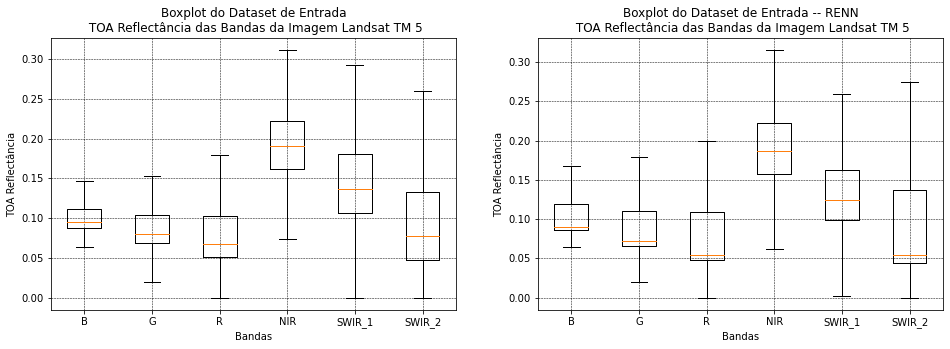

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].boxplot(ds_features, whis=1.5, showfliers=False, labels=['B', 'G', 'R', 'NIR', 'SWIR_1', 'SWIR_2']) 
ax[1].boxplot(ds_features_renn, whis=1.5, showfliers=False, labels=['B', 'G', 'R', 'NIR', 'SWIR_1', 'SWIR_2']) 

ax[0].set_title('Boxplot do Dataset de Entrada\n TOA Reflectância das Bandas da Imagem Landsat TM 5')
ax[0].set_xlabel('Bandas')
ax[0].set_ylabel('TOA Reflectância')
ax[1].set_title('Boxplot do Dataset de Entrada -- RENN\n TOA Reflectância das Bandas da Imagem Landsat TM 5')
ax[1].set_xlabel('Bandas')
ax[1].set_ylabel('TOA Reflectância')

ax[0].grid(color='black', linestyle='--', linewidth=0.5)
ax[1].grid(color='black', linestyle='--', linewidth=0.5)

plt.show()

In [10]:
# Dataset de Saída RENN com valores das Classes do Mapeamento de Cobertura da Terra

ds_target_renn = pd.DataFrame(ds.y_renn, columns=['LC',])
ds_target_renn.T # exibição das linhas com transpor

,0,1,2,3,4,5,6,7,8,9,...,1520408,1520409,1520410,1520411,1520412,1520413,1520414,1520415,1520416,1520417
LC,1,1,1,1,1,1,1,1,1,1,...,6,6,6,6,6,6,6,6,6,6


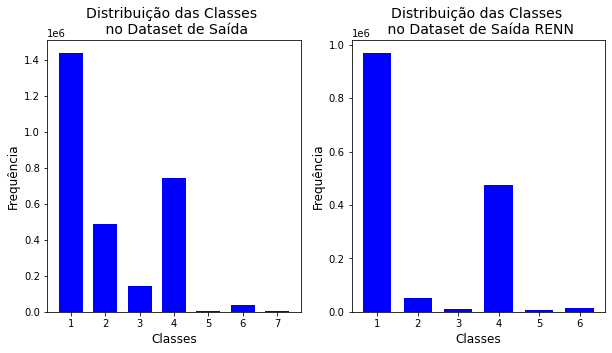

In [11]:
# Distribuição das Classes no Dataset de Saída RENN

unique_renn, counts_renn = np.unique(ds_target_renn, return_counts=True)

fig, ax = plt.subplots(1, 2, figsize =(10, 5))

ax[0].bar(unique, counts, width=0.7, color='blue', align='center')
ax[1].bar(unique_renn, counts_renn, width=0.7, color='blue', align='center')

ax[0].set_title('Distribuição das Classes \n no Dataset de Saída', fontsize=14)
ax[0].set_xlabel('Classes', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[1].set_title('Distribuição das Classes \n no Dataset de Saída RENN', fontsize=14)
ax[1].set_xlabel('Classes', fontsize=12)
ax[1].set_ylabel('Frequência', fontsize=12)

plt.show()

In [12]:
# Salienta-se que o algoritmo RENN não é um método que tem como objetivo balancear as classes 
# alterando a sua distribuição, seu objetivo é criar um conjunto consistente removendo ruidos
# e valores redundantes próximos da borda de decisão sem se ater a balancear o conjunto de dados.

id_classes_renn = pd.Series(unique_renn)
count_classes_renn = pd.Series(counts_renn)
dist_classes_renn = pd.Series(np.round(100*count_classes_renn/count_classes_renn.sum(),2))

frame = [id_classes_renn, dist_classes_renn]
dist_classes_renn = pd.concat(frame, axis=1, keys=['classe', '%'])
dist_classes_renn

,classe,%
0,1,63.73
1,2,3.33
2,3,0.62
3,4,31.17
4,5,0.32
5,6,0.82


### 3.2. Divisão do Dataset em Conjunto de Treinamento (train) e Teste (test)

Para Divisão do Dataset aplicou-se a técnica de partição do conjunto de dados -- **Validação Holdout**, sendo definido a proporção de 70% para o conjunto de treinamento e 30% para teste.

In [13]:
x_train = pd.DataFrame(ds.x_train, columns=['B', 'G', 'R', 'NIR', 'SWIR_1', 'SWIR_2'])
x_train

,B,G,R,NIR,SWIR_1,SWIR_2
0,0.096940,0.084141,0.070410,0.194215,0.170754,0.106797
1,0.118883,0.103230,0.099373,0.113755,0.129312,0.117956
2,0.129854,0.118501,0.118682,0.153985,0.170754,0.162591
3,0.107911,0.087959,0.080065,0.105709,0.139673,0.140273
4,0.118883,0.103230,0.099373,0.174100,0.157804,0.121675
...,...,...,...,...,...,...
1064287,0.131682,0.126137,0.128337,0.158008,0.201835,0.188628
1064288,0.117054,0.118501,0.118682,0.174100,0.186295,0.155152
1064289,0.122540,0.122319,0.121900,0.178123,0.194065,0.166311
1064290,0.096940,0.080323,0.076847,0.121801,0.144853,0.110516


In [14]:
x_test = pd.DataFrame(ds.x_test, columns=['B', 'G', 'R', 'NIR', 'SWIR_1', 'SWIR_2'])
x_test

,B,G,R,NIR,SWIR_1,SWIR_2
0,0.084140,0.053598,0.038229,0.033295,0.012758,0.002647
1,0.085969,0.057416,0.041447,0.166054,0.056790,0.017526
2,0.091455,0.072687,0.057538,0.206284,0.129312,0.062161
3,0.085969,0.068869,0.054320,0.178123,0.103411,0.043563
4,0.087797,0.068869,0.051102,0.190192,0.095641,0.047283
...,...,...,...,...,...,...
456121,0.109740,0.103230,0.092937,0.101686,0.098231,0.095638
456122,0.142653,0.141408,0.147645,0.174100,0.214786,0.199787
456123,0.131682,0.114683,0.115464,0.145939,0.173344,0.162591
456124,0.084140,0.072687,0.054320,0.258583,0.134493,0.047283


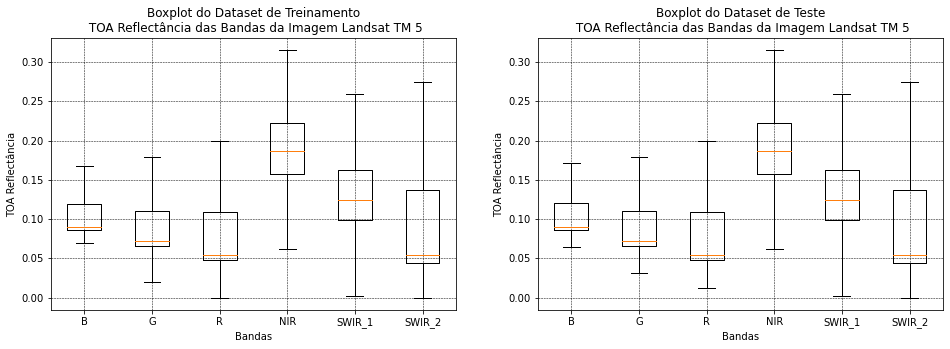

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].boxplot(x_train, whis=1.5, showfliers=False, labels=['B', 'G', 'R', 'NIR', 'SWIR_1', 'SWIR_2']) 
ax[1].boxplot(x_test, whis=1.5, showfliers=False, labels=['B', 'G', 'R', 'NIR', 'SWIR_1', 'SWIR_2']) 

ax[0].set_title('Boxplot do Dataset de Treinamento\n TOA Reflectância das Bandas da Imagem Landsat TM 5')
ax[0].set_xlabel('Bandas')
ax[0].set_ylabel('TOA Reflectância')
ax[1].set_title('Boxplot do Dataset de Teste\n TOA Reflectância das Bandas da Imagem Landsat TM 5')
ax[1].set_xlabel('Bandas')
ax[1].set_ylabel('TOA Reflectância')

ax[0].grid(color='black', linestyle='--', linewidth=0.5)
ax[1].grid(color='black', linestyle='--', linewidth=0.5)

plt.show()

In [16]:
y_train = pd.DataFrame(ds.y_train, columns=['LC',])
y_train.T

,0,1,2,3,4,5,6,7,8,9,...,1064282,1064283,1064284,1064285,1064286,1064287,1064288,1064289,1064290,1064291
LC,1,4,4,3,4,4,4,4,1,4,...,4,4,4,1,1,4,4,4,3,4


In [17]:
unique_train, counts_train = np.unique(y_train, return_counts=True)

id_classes_train = pd.Series(unique_train)
count_classes_train = pd.Series(counts_train)
dist_classes_train = pd.Series(np.round(100*count_classes_train/count_classes_train.sum(),2))

frame = [id_classes_train, dist_classes_train]
dist_classes_train = pd.concat(frame, axis=1, keys=['classe', '%'])
dist_classes_train

,classe,%
0,1,63.73
1,2,3.33
2,3,0.62
3,4,31.17
4,5,0.32
5,6,0.82


In [18]:
y_test = pd.DataFrame(ds.y_test, columns=['LC',])
y_test.T

,0,1,2,3,4,5,6,7,8,9,...,456116,456117,456118,456119,456120,456121,456122,456123,456124,456125
LC,6,1,1,1,1,1,1,4,1,4,...,1,1,4,1,1,4,4,4,1,4


In [19]:
unique_test, counts_test = np.unique(y_test, return_counts=True)

id_classes_test = pd.Series(unique_test)
count_classes_test = pd.Series(counts_test)
dist_classes_test = pd.Series(np.round(100*count_classes_test/count_classes_test.sum(),2))

frame = [id_classes_test, dist_classes_test]
dist_classes_test = pd.concat(frame, axis=1, keys=['classe', '%'])
dist_classes_test

,classe,%
0,1,63.73
1,2,3.33
2,3,0.62
3,4,31.17
4,5,0.32
5,6,0.82


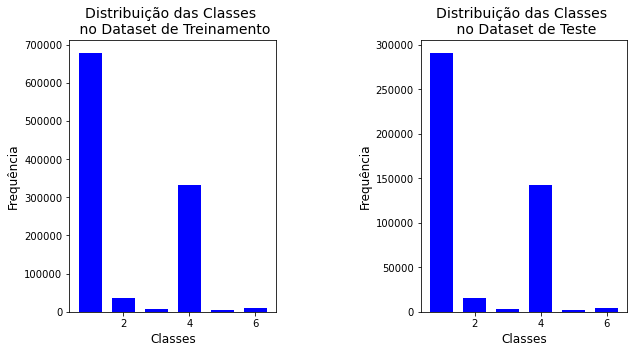

In [20]:
# Distribuição das Classes no Dataset de Treinamento e Teste

# A divisão do Dataset ocorreu de forma estratificada, com
# Distribuição igual nas diferentes classes

fig, ax = plt.subplots(1, 2, figsize =(10, 5))

ax[0].bar(unique_train, counts_train, width=0.7, color='blue', align='center')
ax[1].bar(unique_test, counts_test, width=0.7, color='blue', align='center')

ax[0].set_title('Distribuição das Classes \n no Dataset de Treinamento', fontsize=14)
ax[0].set_xlabel('Classes', fontsize=12)
ax[0].set_ylabel('Frequência', fontsize=12)
ax[1].set_title('Distribuição das Classes \n no Dataset de Teste', fontsize=14)
ax[1].set_xlabel('Classes', fontsize=12)
ax[1].set_ylabel('Frequência', fontsize=12)

plt.subplots_adjust(wspace=0.7)
plt.show()

## 4. Modelagem

A Modelagem consiste na construção do Modelo e envolve a seleção dos algoritmos e a determinação de seus hiperparâmetros.

A Classe CreateModelHyperopt cria o Modelo após busca dos Hiperparâmetros Otimizados.

### 4.1. Gaussian Naive Bayes

In [21]:
# Criando o Modelo do Algoritmo Gaussian Naive Bayes com Hiperparâmetros Otimizados
CreateModelHyperopt(algorithm_list[1], ds.x_renn, ds.y_renn, ds.dump_dir)

In [22]:
# Apresentação dos Testes de Otimização dos Hiperparâmetros
tpe_trials_gnb = pickle.load(open(os.path.join(dump_path, f'trials_{algorithm_list[1]}.sav'), 'rb'))
for tpe_gnb in tpe_trials_gnb:
    print(tpe_gnb)

{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': -0.9699392542385417, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'var_smoothing': [0]}, 'vals': {'var_smoothing': [3]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 9, 10, 0, 48, 57, 196000), 'refresh_time': datetime.datetime(2020, 9, 10, 0, 48, 59, 229000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': -0.9699392542385417, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'var_smoothing': [1]}, 'vals': {'var_smoothing': [3]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2020, 9, 10, 0, 48, 59, 236000), 'refresh_time': datetime.datetime(2020, 9, 10, 0, 49, 0, 541000)}
{'state': 2, 'tid': 2, 'spec': None, 'result': {'loss': -0.9699392542385417, 'status': 'ok'}, 'misc': {'tid': 2, 'cmd': ('domain_attachment', 'FMinIter_Domain'

In [23]:
var_smoothing = np.logspace(0, -9, num=10)

resultados_gnb = [
    [
        tpe_gnb['tid'], 
        np.round(-1*tpe_gnb['result']['loss'],4),
        var_smoothing[tpe_gnb['misc']['vals']['var_smoothing'][0]]
    ] for tpe_gnb in tpe_trials_gnb]
resultados_gnb = pd.DataFrame(resultados_gnb, columns=['id', 'f1_weight', 'var_smoothing'])
resultados_gnb

,id,f1_weight,var_smoothing
0,0,0.9699,1.000000e-03
1,1,0.9699,1.000000e-03
2,2,0.9699,1.000000e-03
3,3,0.9693,1.000000e-04
4,4,0.9720,1.000000e-01
...,...,...,...
95,95,0.9285,1.000000e+00
96,96,0.9729,1.000000e-02
97,97,0.9692,1.000000e-08
98,98,0.9729,1.000000e-02


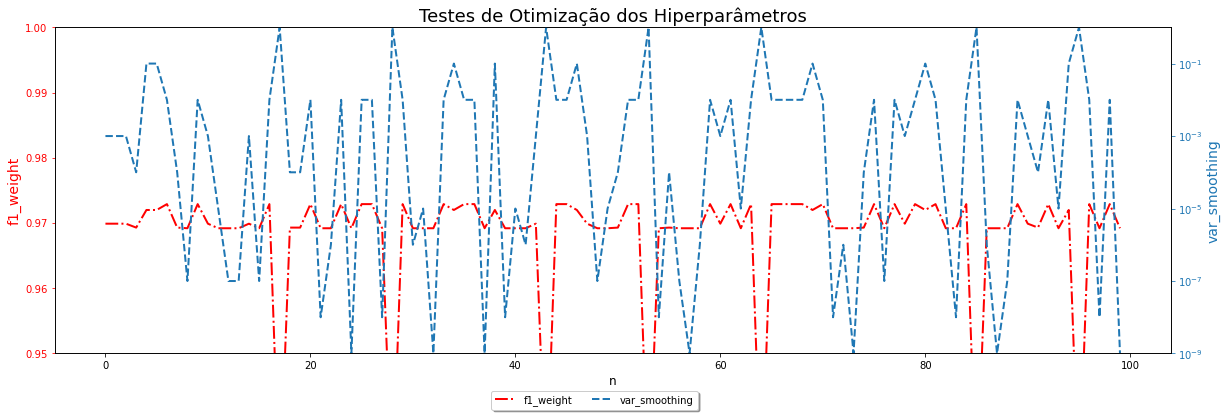

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

bx = ax.twinx()

ax.plot(resultados_gnb['id'], resultados_gnb['f1_weight'], color='red', linestyle='-.', linewidth=2.0)
bx.plot(resultados_gnb['id'], resultados_gnb['var_smoothing'], color='C0', linestyle='--', linewidth=2.0)

ax.set_title('Testes de Otimização dos Hiperparâmetros', fontsize=18)

ax.set_xlabel('n', fontsize=12)

ax.set_ylabel('f1_weight', fontsize=14, color='red')
bx.set_ylabel('var_smoothing', fontsize=14, color="C0")

ax.tick_params(axis="y", colors="red")
bx.tick_params(axis="y", colors="C0")

ax.set_ylim(0.9500, 1.0000)
bx.set_ylim(1e-9, 1e+0)

bx.set_yscale('log', basey=10)

fig.legend(['f1_weight', 'var_smoothing'], loc='upper center', 
           bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

In [25]:
# Carregando o Modelo com seus Hiperparâmetros Otimizados
pickle.load(open(os.path.join(dump_path, f'algorithm_{algorithm_list[1]}.sav'), 'rb'))

GaussianNB(var_smoothing=0.01)

### 4.2. Decision Tree

In [26]:
# Criando o Modelo do Algoritmo Decision Tree com Hiperparâmetros Otimizados
CreateModelHyperopt(algorithm_list[2], ds.x_renn, ds.y_renn, ds.dump_dir)

In [27]:
# Apresentação dos Testes de Otimização dos Hiperparâmetros
tpe_trials_dt = pickle.load(open(os.path.join(dump_path, f'trials_{algorithm_list[2]}.sav'), 'rb'))
#for tpe_dt in tpe_trials_dt:
#    print(tpe_dt)

In [28]:
min_samples_split = list(range(2, 10))
min_samples_leaf = list(range(1, 10))
max_features = ['sqrt', 'log2']

resultados_dt = [
    [
        tpe_dt['tid'], 
        np.round(-1*tpe_dt['result']['loss'],4),
        min_samples_split[tpe_dt['misc']['vals']['min_samples_split'][0]],
        min_samples_leaf[tpe_dt['misc']['vals']['min_samples_leaf'][0]],
        max_features[tpe_dt['misc']['vals']['max_features'][0]]
    ] for tpe_dt in tpe_trials_dt]
resultados_dt = pd.DataFrame(resultados_dt, columns=['id', 'f1_weight', 'min_samples_split', 
                                                     'min_samples_leaf', 'max_features'])
resultados_dt

,id,f1_weight,min_samples_split,min_samples_leaf,max_features
0,0,0.9814,6,4,sqrt
1,1,0.9814,5,4,sqrt
2,2,0.9814,7,4,sqrt
3,3,0.9789,6,6,log2
4,4,0.9762,3,8,log2
...,...,...,...,...,...
95,95,0.9814,7,4,log2
96,96,0.9858,8,1,log2
97,97,0.9888,2,1,sqrt
98,98,0.9805,2,5,sqrt


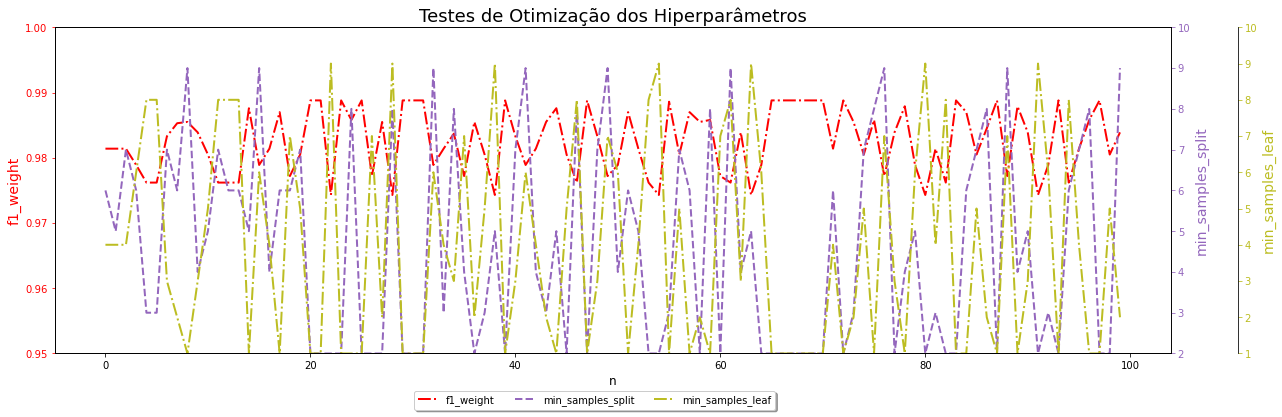

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

bx = ax.twinx()
cx = ax.twinx()

cx.spines["right"].set_position(("axes", 1.06))

ax.plot(resultados_dt['id'], resultados_dt['f1_weight'], color='red', linestyle='-.', linewidth=2.0)
bx.plot(resultados_dt['id'], resultados_dt['min_samples_split'], color='C4', linestyle='--', linewidth=2.0)
cx.plot(resultados_dt['id'], resultados_dt['min_samples_leaf'], color='C8', linestyle='-.', linewidth=2.0)

ax.set_title('Testes de Otimização dos Hiperparâmetros', fontsize=18)

ax.set_xlabel('n', fontsize=12)

ax.set_ylabel('f1_weight', fontsize=14, color='red')
bx.set_ylabel('min_samples_split', fontsize=14, color="C4")
cx.set_ylabel('min_samples_leaf', fontsize=14, color="C8")

ax.tick_params(axis="y", colors="red")
bx.tick_params(axis="y", colors="C4")
cx.tick_params(axis="y", colors="C8")

ax.set_ylim(0.9500, 1.0000)
bx.set_ylim(2, 10)
cx.set_ylim(1, 10)

fig.legend(['f1_weight', 'min_samples_split', 'min_samples_leaf'], loc='upper center', 
           bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=True, ncol=3)
plt.show()

In [30]:
# Carregando o Modelo com seus Hiperparâmetros Otimizados
pickle.load(open(os.path.join(dump_path, f'algorithm_{algorithm_list[2]}.sav'), 'rb'))

DecisionTreeClassifier(class_weight='balanced', max_features='log2',
                       min_impurity_decrease=1e-07,
                       min_weight_fraction_leaf=1e-07, random_state=0)

### 4.3. Random Forest

In [31]:
# Criando o Modelo do Algoritmo Random Forest com Hiperparâmetros Otimizados
CreateModelHyperopt(algorithm_list[3], ds.x_renn, ds.y_renn, ds.dump_dir)

In [32]:
# Apresentação dos Testes de Otimização dos Hiperparâmetros
tpe_trials_rf = pickle.load(open(os.path.join(dump_path, f'trials_{algorithm_list[3]}.sav'), 'rb'))
#for tpe_rf in tpe_trials_rf:
#    print(tpe_rf)

In [33]:
n_estimators = list(range(10, 100, 5))
max_depth = list(range(0, 30))
min_samples_split = list(range(2, 10))
min_samples_leaf = list(range(1, 10))
max_features = ['sqrt', 'log2']

resultados_rf = [
    [
        tpe_rf['tid'], 
        np.round(-1*tpe_rf['result']['loss'],4),
        n_estimators[tpe_rf['misc']['vals']['n_estimators'][0]],
        max_depth[tpe_rf['misc']['vals']['max_depth'][0]],
        min_samples_split[tpe_rf['misc']['vals']['min_samples_split'][0]],
        min_samples_leaf[tpe_rf['misc']['vals']['min_samples_leaf'][0]],
        max_features[tpe_rf['misc']['vals']['max_features'][0]]
    ] for tpe_rf in tpe_trials_rf]
resultados_rf = pd.DataFrame(resultados_rf, columns=['id', 'f1_weight', 'n_estimators', 'max_depth', 
                                                     'min_samples_split', 'min_samples_leaf', 'max_features'])
resultados_rf

,id,f1_weight,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features
0,0,0.0000,70,0,5,3,sqrt
1,1,0.0000,65,0,7,4,sqrt
2,2,0.9850,75,14,5,6,sqrt
3,3,0.9929,30,24,7,4,sqrt
4,4,0.9857,15,15,9,6,log2
...,...,...,...,...,...,...,...
95,95,0.9929,70,26,6,4,sqrt
96,96,0.9903,45,18,5,8,log2
97,97,0.9907,75,16,4,1,log2
98,98,0.9913,65,19,5,7,log2


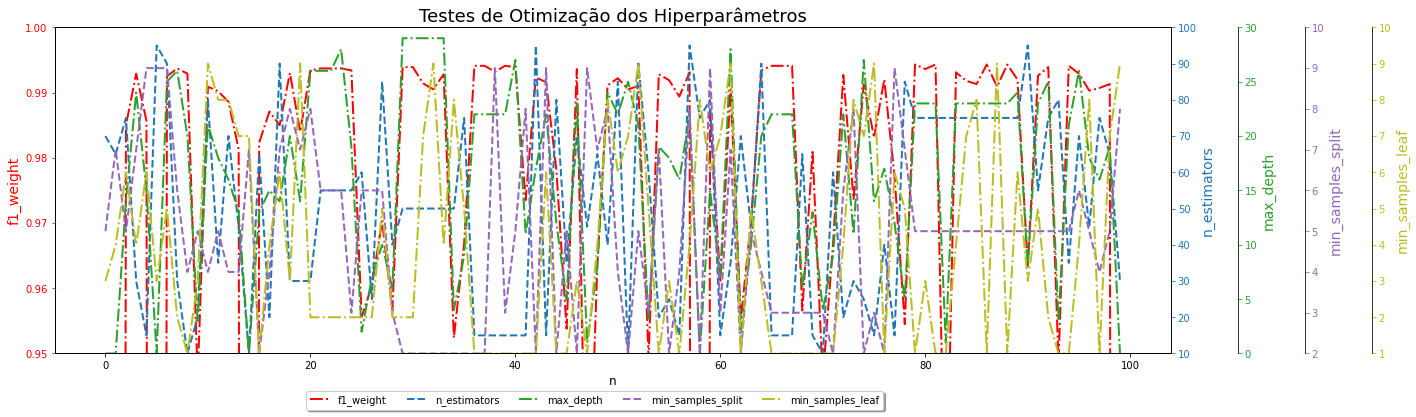

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

bx = ax.twinx()
cx = ax.twinx()
dx = ax.twinx()
ex = ax.twinx()

cx.spines["right"].set_position(("axes", 1.06))
dx.spines["right"].set_position(("axes", 1.12))
ex.spines["right"].set_position(("axes", 1.18))

ax.plot(resultados_rf['id'], resultados_rf['f1_weight'], color='red', linestyle='-.', linewidth=2.0)
bx.plot(resultados_rf['id'], resultados_rf['n_estimators'], color='C0', linestyle='--', linewidth=2.0)
cx.plot(resultados_rf['id'], resultados_rf['max_depth'], color='C2', linestyle='-.', linewidth=2.0)
dx.plot(resultados_rf['id'], resultados_rf['min_samples_split'], color='C4', linestyle='--', linewidth=2.0)
ex.plot(resultados_rf['id'], resultados_rf['min_samples_leaf'], color='C8', linestyle='-.', linewidth=2.0)

ax.set_title('Testes de Otimização dos Hiperparâmetros', fontsize=18)

ax.set_xlabel('n', fontsize=12)

ax.set_ylabel('f1_weight', fontsize=14, color='red')
bx.set_ylabel('n_estimators', fontsize=14, color="C0")
cx.set_ylabel('max_depth', fontsize=14, color="C2")
dx.set_ylabel('min_samples_split', fontsize=14, color="C4")
ex.set_ylabel('min_samples_leaf', fontsize=14, color="C8")

ax.tick_params(axis="y", colors="red")
bx.tick_params(axis="y", colors="C0")
cx.tick_params(axis="y", colors="C2")
dx.tick_params(axis="y", colors="C4")
ex.tick_params(axis="y", colors="C8")

ax.set_ylim(0.9500, 1.0000)
bx.set_ylim(10, 100)
cx.set_ylim(0, 30)
dx.set_ylim(2, 10)
ex.set_ylim(1, 10)

fig.legend(['f1_weight', 'n_estimators','max_depth','min_samples_split', 'min_samples_leaf'], loc='upper center', 
           bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=True, ncol=5)
plt.show()

In [35]:
# Carregando o Modelo com seus Hiperparâmetros Otimizados
pickle.load(open(os.path.join(dump_path, f'algorithm_{algorithm_list[3]}.sav'), 'rb'))

RandomForestClassifier(class_weight='balanced', max_depth=23,
                       max_features='log2', min_impurity_decrease=1e-07,
                       min_samples_split=5, min_weight_fraction_leaf=1e-07,
                       n_estimators=75, random_state=0)

### 4.4. KNeighbors

In [36]:
# Criando o Modelo do Algoritmo KNeighbors com Hiperparâmetros Otimizados
CreateModelHyperopt(algorithm_list[4], ds.x_renn, ds.y_renn, ds.dump_dir)

In [37]:
# Apresentação dos Testes de Otimização dos Hiperparâmetros
tpe_trials_knn = pickle.load(open(os.path.join(dump_path, f'trials_{algorithm_list[4]}.sav'), 'rb'))
#for tpe_knn in tpe_trials_knn:
#    print(tpe_knn)

In [38]:
n_neighbors = list(range(1, 10))
leaf_size = list(range(1, 30))

resultados_knn = [
    [
        tpe_knn['tid'], 
        np.round(-1*tpe_knn['result']['loss'],4),
        n_neighbors[tpe_knn['misc']['vals']['n_neighbors'][0]],
        leaf_size[tpe_knn['misc']['vals']['leaf_size'][0]]
    ] for tpe_knn in tpe_trials_knn]
resultados_knn = pd.DataFrame(resultados_knn, columns=['id', 'f1_weight', 'n_neighbors', 'leaf_size'])
resultados_knn

,id,f1_weight,n_neighbors,leaf_size
0,0,0.9963,4,19
1,1,0.9963,4,29
2,2,0.9963,4,15
3,3,0.9961,5,6
4,4,0.9967,2,24
...,...,...,...,...
66,66,0.9967,2,7
67,67,0.9967,2,8
68,68,0.9967,2,8
69,69,0.9967,2,1


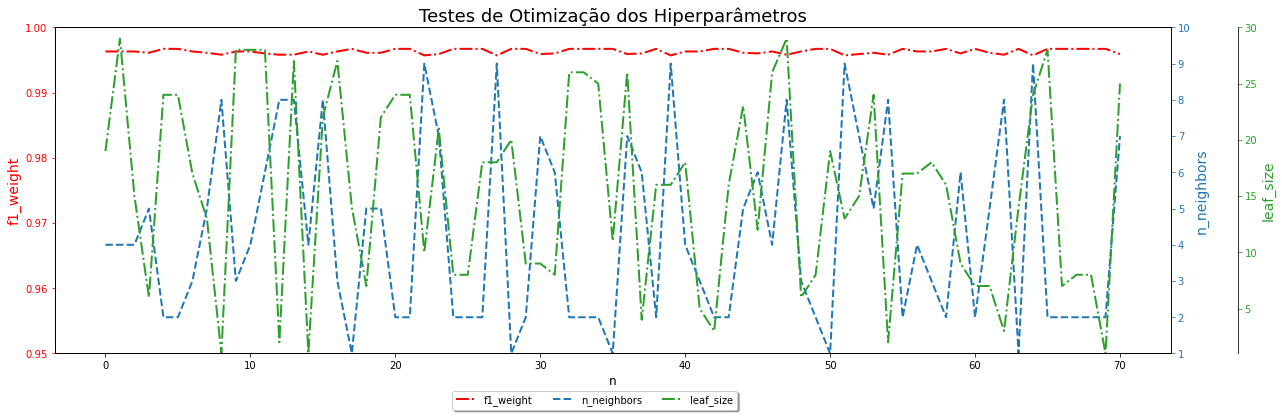

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

bx = ax.twinx()
cx = ax.twinx()

cx.spines["right"].set_position(("axes", 1.06))

ax.plot(resultados_knn['id'], resultados_knn['f1_weight'], color='red', linestyle='-.', linewidth=2.0)
bx.plot(resultados_knn['id'], resultados_knn['n_neighbors'], color='C0', linestyle='--', linewidth=2.0)
cx.plot(resultados_knn['id'], resultados_knn['leaf_size'], color='C2', linestyle='-.', linewidth=2.0)

ax.set_title('Testes de Otimização dos Hiperparâmetros', fontsize=18)

ax.set_xlabel('n', fontsize=12)

ax.set_ylabel('f1_weight', fontsize=14, color='red')
bx.set_ylabel('n_neighbors', fontsize=14, color="C0")
cx.set_ylabel('leaf_size', fontsize=14, color="C2")

ax.tick_params(axis="y", colors="red")
bx.tick_params(axis="y", colors="C0")
cx.tick_params(axis="y", colors="C2")

ax.set_ylim(0.9500, 1.0000)
bx.set_ylim(1, 10)
cx.set_ylim(1, 30)

fig.legend(['f1_weight', 'n_neighbors','leaf_size'], loc='upper center', bbox_to_anchor=(0.5, 0.05), 
           fancybox=True, shadow=True, ncol=5)
plt.show()

In [40]:
# Carregando o Modelo com seus Hiperparâmetros Otimizados
pickle.load(open(os.path.join(dump_path, f'algorithm_{algorithm_list[4]}.sav'), 'rb'))

KNeighborsClassifier(leaf_size=24, n_neighbors=2, p=6, weights='distance')

### 4.5. Logistic Regression

In [41]:
# Criando o Modelo do Algoritmo Logistic Regression com Hiperparâmetros Otimizados
CreateModelHyperopt(algorithm_list[5], ds.x_renn, ds.y_renn, ds.dump_dir)

In [42]:
# Apresentação dos Testes de Otimização dos Hiperparâmetros
tpe_trials_lr = pickle.load(open(os.path.join(dump_path, f'trials_{algorithm_list[5]}.sav'), 'rb'))
#for tpe_lr in tpe_trials_lr:
#    print(tpe_lr)

In [43]:
max_iter = list(range(100, 500, 20))

resultados_lr = [
    [
        tpe_lr['tid'], 
        np.round(-1*tpe_lr['result']['loss'],4),
        np.round(tpe_lr['misc']['vals']['C'][0],2),
        max_iter[tpe_lr['misc']['vals']['max_iter'][0]]
    ] for tpe_lr in tpe_trials_lr]
resultados_lr = pd.DataFrame(resultados_lr, columns=['id', 'f1_weight', 'C', 'max_iter'])
resultados_lr

,id,f1_weight,C,max_iter
0,0,0.9792,39.65,340
1,1,0.9793,86.93,320
2,2,0.9792,44.96,360
3,3,0.9792,43.38,180
4,4,0.9792,22.24,120
...,...,...,...,...
95,95,0.9792,45.31,340
96,96,0.9793,69.63,260
97,97,0.9793,79.92,140
98,98,0.9793,55.26,280


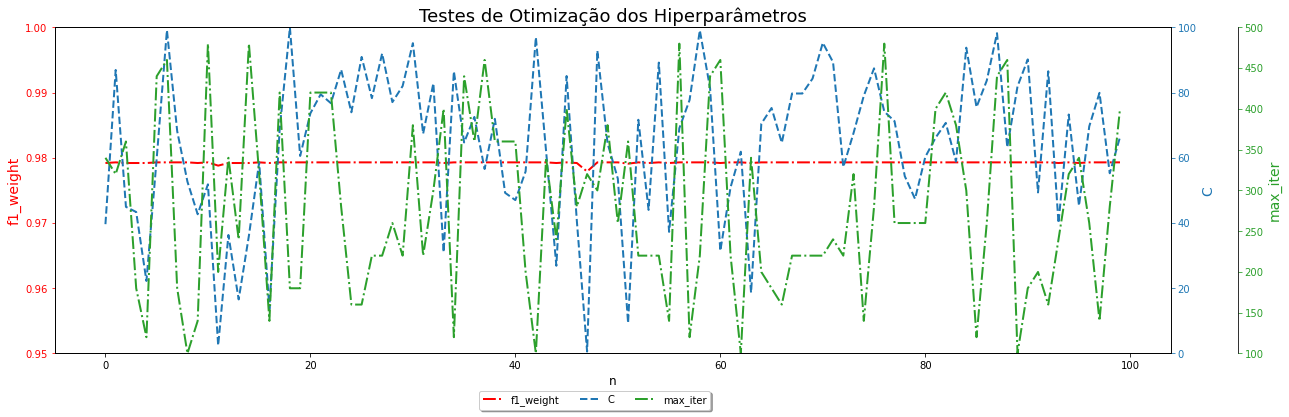

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

bx = ax.twinx()
cx = ax.twinx()

cx.spines["right"].set_position(("axes", 1.06))

ax.plot(resultados_lr['id'], resultados_lr['f1_weight'], color='red', linestyle='-.', linewidth=2.0)
bx.plot(resultados_lr['id'], resultados_lr['C'], color='C0', linestyle='--', linewidth=2.0)
cx.plot(resultados_lr['id'], resultados_lr['max_iter'], color='C2', linestyle='-.', linewidth=2.0)

ax.set_title('Testes de Otimização dos Hiperparâmetros', fontsize=18)

ax.set_xlabel('n', fontsize=12)

ax.set_ylabel('f1_weight', fontsize=14, color='red')
bx.set_ylabel('C', fontsize=14, color="C0")
cx.set_ylabel('max_iter', fontsize=14, color="C2")

ax.tick_params(axis="y", colors="red")
bx.tick_params(axis="y", colors="C0")
cx.tick_params(axis="y", colors="C2")

ax.set_ylim(0.9500, 1.0000)
bx.set_ylim(0, 100)
cx.set_ylim(100, 500)

fig.legend(['f1_weight', 'C','max_iter'], loc='upper center', bbox_to_anchor=(0.5, 0.05), 
           fancybox=True, shadow=True, ncol=5)
plt.show()

In [45]:
# Carregando o Modelo com seus Hiperparâmetros Otimizados
pickle.load(open(os.path.join(dump_path, f'algorithm_{algorithm_list[5]}.sav'), 'rb'))

LogisticRegression(C=71.66084098551138, class_weight='balanced', max_iter=220,
                   multi_class='ovr', random_state=0)

### 4.6. Linear Support Vector

In [46]:
# Criando o Modelo do Algoritmo Linear Support Vector com Hiperparâmetros Otimizados
CreateModelHyperopt(algorithm_list[6], ds.x_renn, ds.y_renn, ds.dump_dir)

In [47]:
# Apresentação dos Testes de Otimização dos Hiperparâmetros
tpe_trials_lsv = pickle.load(open(os.path.join(dump_path, f'trials_{algorithm_list[6]}.sav'), 'rb'))
#for tpe_lsv in tpe_trials_lsv:
#    print(tpe_lsv)

In [48]:
resultados_lsv = [
    [
        tpe_lsv['tid'], 
        np.round(-1*tpe_lsv['result']['loss'],4),
        np.round(tpe_lsv['misc']['vals']['C'][0],2)
    ] for tpe_lsv in tpe_trials_lsv]
resultados_lsv = pd.DataFrame(resultados_lsv, columns=['id', 'f1_weight', 'C'])
resultados_lsv

,id,f1_weight,C
0,0,0.9795,49.12
1,1,0.9796,53.57
2,2,0.9802,26.58
3,3,0.9798,53.34
4,4,0.9808,15.59
5,5,0.9803,24.02
6,6,0.9790,83.98
7,7,0.9795,96.75
8,8,0.9797,51.54
9,9,0.9810,10.11


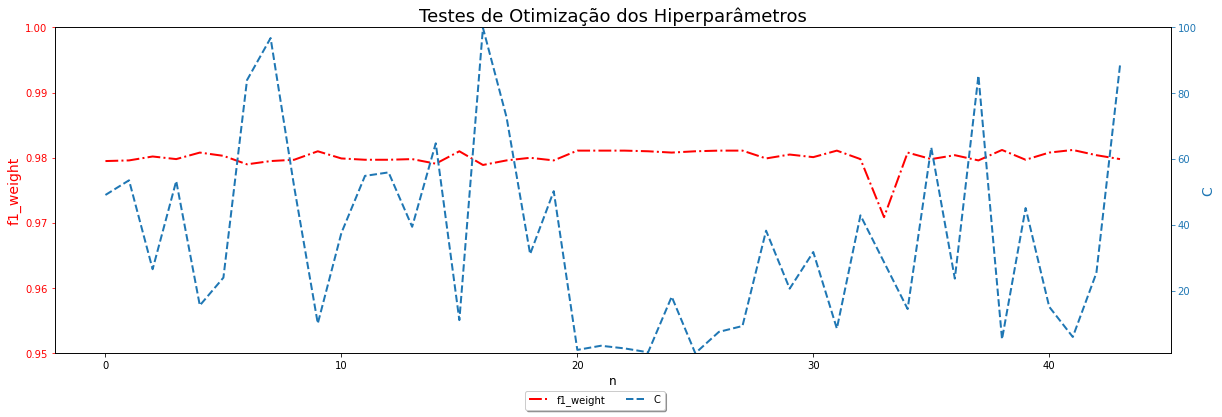

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

bx = ax.twinx()

ax.plot(resultados_lsv['id'], resultados_lsv['f1_weight'], color='red', linestyle='-.', linewidth=2.0)
bx.plot(resultados_lsv['id'], resultados_lsv['C'], color='C0', linestyle='--', linewidth=2.0)

ax.set_title('Testes de Otimização dos Hiperparâmetros', fontsize=18)

ax.set_xlabel('n', fontsize=12)

ax.set_ylabel('f1_weight', fontsize=14, color='red')
bx.set_ylabel('C', fontsize=14, color="C0")

ax.tick_params(axis="y", colors="red")
bx.tick_params(axis="y", colors="C0")

ax.set_ylim(0.9500, 1.0000)
bx.set_ylim(1, 100)

fig.legend(['f1_weight', 'C'], loc='upper center', bbox_to_anchor=(0.5, 0.05), 
           fancybox=True, shadow=True, ncol=2)
plt.show()

In [50]:
# Carregando o Modelo com seus Hiperparâmetros Otimizados
pickle.load(open(os.path.join(dump_path, f'algorithm_{algorithm_list[6]}.sav'), 'rb'))

LinearSVC(C=5.333547938379196, class_weight='balanced', random_state=0)

### 4.7. Multi Layer Perceptron

In [51]:
# Criando o Modelo do Algoritmo Multi Layer Perceptron com Hiperparâmetros Otimizados
CreateModelHyperopt(algorithm_list[7], ds.x_renn, ds.y_renn, ds.dump_dir)

In [52]:
# Apresentação dos Testes de Otimização dos Hiperparâmetros
tpe_trials_mlp = pickle.load(open(os.path.join(dump_path, f'trials_{algorithm_list[7]}.sav'), 'rb'))
#for tpe_mlp in tpe_trials_mlp:
#    print(tpe_mlp)

In [53]:
alpha = np.logspace(-2, -7, num=6)

resultados_mlp = [
    [
        tpe_mlp['tid'], 
        np.round(-1*tpe_mlp['result']['loss'],4),
        alpha[tpe_mlp['misc']['vals']['alpha'][0]]
    ] for tpe_mlp in tpe_trials_mlp]
resultados_mlp = pd.DataFrame(resultados_mlp, columns=['id', 'f1_weight', 'alpha'])
resultados_mlp

,id,f1_weight,alpha
0,0,0.9922,1.000000e-06
1,1,0.9922,1.000000e-05
2,2,0.9922,1.000000e-07
3,3,0.9922,1.000000e-06
4,4,0.9920,1.000000e-03
...,...,...,...
95,95,0.9915,1.000000e-02
96,96,0.9922,1.000000e-05
97,97,0.9920,1.000000e-03
98,98,0.9922,1.000000e-05


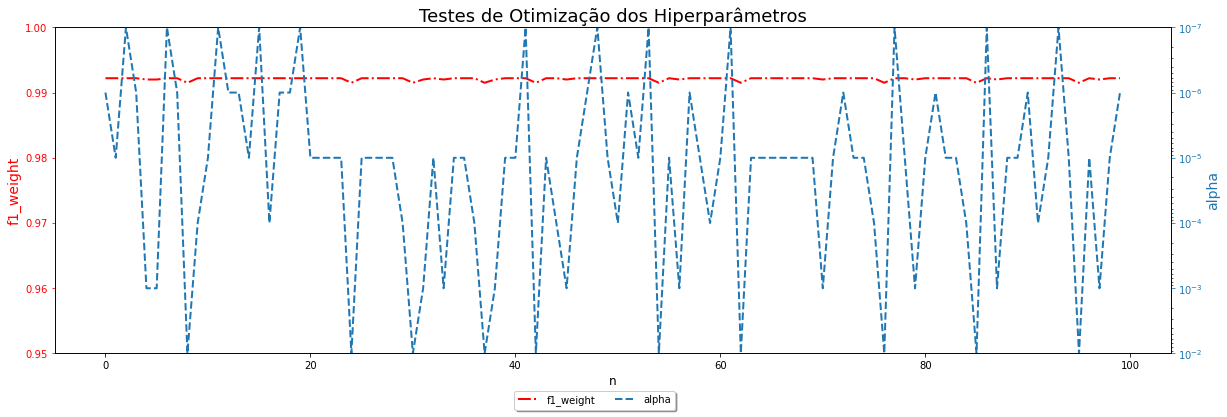

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

bx = ax.twinx()

ax.plot(resultados_mlp['id'], resultados_mlp['f1_weight'], color='red', linestyle='-.', linewidth=2.0)
bx.plot(resultados_mlp['id'], resultados_mlp['alpha'], color='C0', linestyle='--', linewidth=2.0)

ax.set_title('Testes de Otimização dos Hiperparâmetros', fontsize=18)

ax.set_xlabel('n', fontsize=12)

ax.set_ylabel('f1_weight', fontsize=14, color='red')
bx.set_ylabel('alpha', fontsize=14, color="C0")

ax.tick_params(axis="y", colors="red")
bx.tick_params(axis="y", colors="C0")

ax.set_ylim(0.9500, 1.0000)
bx.set_ylim(1e-2, 1e-7)

bx.set_yscale('log', basey=10)

fig.legend(['f1_weight', 'alpha'], loc='upper center', bbox_to_anchor=(0.5, 0.05), 
           fancybox=True, shadow=True, ncol=2)
plt.show()

In [55]:
# Carregando o Modelo com seus Hiperparâmetros Otimizados
pickle.load(open(os.path.join(dump_path, f'algorithm_{algorithm_list[7]}.sav'), 'rb'))

MLPClassifier(activation='tanh', alpha=1e-05, hidden_layer_sizes=(10, 10, 10),
              learning_rate='adaptive', random_state=0)

## 5. Avaliação

Nesta etapa existe a preocupação em medir o grau de acerto da predição, analisando o quanto os valores preditos se afastam do conjunto de dados de validação, sendo apresentado abaixo as métricas obtidas em cada algoritmo.

### 5.1. Gaussian Naive Bayes

In [56]:
stats_gnb = pickle.load(open(os.path.join(dump_path, f'stats_{algorithm_list[1]}.sav'), 'rb'))
stats_gnb

,cohen_kappa,roc_auc,f1_score,accuracy,precision,recall,matthews_corrcoef
base,0.590876,0.802902,0.730268,0.742552,0.724052,0.742552,0.592711
clean,0.591792,0.803464,0.731321,0.743254,0.725412,0.743254,0.593589
renn,0.939593,0.980541,0.973003,0.969723,0.977455,0.969723,0.939868
train,0.93973,0.980549,0.972995,0.969794,0.977371,0.969794,0.940002
test,0.938685,0.980494,0.972869,0.969245,0.977709,0.969245,0.938981


### 5.2. Decision Tree

In [57]:
stats_dt = pickle.load(open(os.path.join(dump_path, f'stats_{algorithm_list[2]}.sav'), 'rb'))
stats_dt

,cohen_kappa,roc_auc,f1_score,accuracy,precision,recall,matthews_corrcoef
base,0.689432,0.867519,0.802211,0.783288,0.848939,0.783288,0.699043
clean,0.73549,0.887137,0.831785,0.818891,0.864029,0.818891,0.741858
renn,0.975136,0.993681,0.99067,0.987492,0.99552,0.987492,0.975483
train,0.983678,0.995876,0.993482,0.991832,0.996297,0.991832,0.983825
test,0.984171,0.995999,0.993555,0.992081,0.996134,0.992081,0.984308


### 5.3. Random Forest

In [58]:
stats_rf = pickle.load(open(os.path.join(dump_path, f'stats_{algorithm_list[3]}.sav'), 'rb'))
stats_rf

,cohen_kappa,roc_auc,f1_score,accuracy,precision,recall,matthews_corrcoef
base,0.721578,0.87836,0.822337,0.810909,0.847242,0.810909,0.726717
clean,0.735277,0.88402,0.83049,0.821505,0.850739,0.821505,0.739593
renn,0.99483,0.998561,0.997501,0.997432,0.997648,0.997432,0.994839
train,0.994882,0.998613,0.997532,0.997457,0.9977,0.997457,0.99489
test,0.995066,0.998724,0.997618,0.997549,0.997785,0.997549,0.995076


### 5.4. Kneighbors

In [59]:
stats_knn = pickle.load(open(os.path.join(dump_path, f'stats_{algorithm_list[4]}.sav'), 'rb'))
stats_knn

,cohen_kappa,roc_auc,f1_score,accuracy,precision,recall,matthews_corrcoef
base,0.903485,0.944774,0.937487,0.938869,0.940315,0.938869,0.905531
clean,0.90417,0.94522,0.938072,0.939341,0.940704,0.939341,0.906182
renn,0.999842,0.999892,0.999921,0.999922,0.999922,0.999922,0.999842
train,0.999844,0.999894,0.999922,0.999923,0.999923,0.999923,0.999845
test,0.999836,0.999888,0.999918,0.999919,0.999919,0.999919,0.999836


### 5.5. Logistic Regression

In [60]:
stats_lr = pickle.load(open(os.path.join(dump_path, f'stats_{algorithm_list[5]}.sav'), 'rb'))
stats_lr

,cohen_kappa,roc_auc,f1_score,accuracy,precision,recall,matthews_corrcoef
base,0.605318,0.823588,0.752731,0.737791,0.769384,0.737791,0.606318
clean,0.619131,0.828204,0.758044,0.749424,0.768724,0.749424,0.619685
renn,0.957288,0.98626,0.979184,0.978716,0.980953,0.978716,0.95737
train,0.957396,0.986256,0.979179,0.978773,0.980921,0.978773,0.957476
test,0.957209,0.986247,0.979183,0.978677,0.981056,0.978677,0.957292


### 5.6. Linear Support Vector

In [61]:
stats_lsv = pickle.load(open(os.path.join(dump_path, f'stats_{algorithm_list[6]}.sav'), 'rb'))
stats_lsv

,cohen_kappa,roc_auc,f1_score,accuracy,precision,recall,matthews_corrcoef
base,0.624997,0.820819,0.745443,0.76338,0.738417,0.76338,0.627401
clean,0.626475,0.821448,0.747363,0.764455,0.740405,0.764455,0.628727
renn,0.966868,0.987456,0.98105,0.983631,0.980801,0.983631,0.966919
train,0.967052,0.987456,0.981118,0.983725,0.980953,0.983725,0.967104
test,0.966526,0.987367,0.980897,0.983461,0.98053,0.983461,0.966576


### 5.7. Multi Layer Perceptron

In [62]:
stats_mlp = pickle.load(open(os.path.join(dump_path, f'stats_{algorithm_list[7]}.sav'), 'rb'))
stats_mlp

,cohen_kappa,roc_auc,f1_score,accuracy,precision,recall,matthews_corrcoef
base,0.649956,0.828849,0.765538,0.78083,0.760797,0.78083,0.652579
clean,0.655169,0.833487,0.771992,0.782349,0.768012,0.782349,0.656457
renn,0.986539,0.993236,0.992715,0.993357,0.992771,0.993357,0.986562
train,0.98667,0.994156,0.992903,0.993405,0.992917,0.993405,0.986676
test,0.985136,0.993479,0.991899,0.992651,0.992054,0.992651,0.985147


## 6. Conclusão

Por estarmos tratando de um Dataset com dados não balanceados a medida de desempenho utilizada para avaliação dos modelos será o Kappa, métrica considerada mais robusta que leva em consideração a possibilidade da concordância ocorrer por acaso.

In [63]:
field = 'cohen_kappa'

gnb = pd.Series(stats_gnb[field])
dt = pd.Series(stats_dt[field])
rf = pd.Series(stats_rf[field])
knn = pd.Series(stats_knn[field])
lr = pd.Series(stats_lr[field])
lsv = pd.Series(stats_lsv[field])
mlp = pd.Series(stats_mlp[field])

frame = [gnb, dt, rf, knn, lr, lsv, mlp]

stats = pd.concat(frame, axis=1, keys=['gaussian_naive_bayes', 'decision_tree', 'random_forest', 'kneighbors', 
                                       'logistic_regression', 'linear_support_vector', 'multi_layer_perceptron'])
stats

,gaussian_naive_bayes,decision_tree,random_forest,kneighbors,logistic_regression,linear_support_vector,multi_layer_perceptron
base,0.590876,0.689432,0.721578,0.903485,0.605318,0.624997,0.649956
clean,0.591792,0.73549,0.735277,0.90417,0.619131,0.626475,0.655169
renn,0.939593,0.975136,0.99483,0.999842,0.957288,0.966868,0.986539
train,0.93973,0.983678,0.994882,0.999844,0.957396,0.967052,0.98667
test,0.938685,0.984171,0.995066,0.999836,0.957209,0.966526,0.985136


Observa-se que houve uma pequena melhora do **Kappa** em todos os algoritmos avaliados ao se comparar o Dataset Inicial (**base**) com o Dataset resultante da realização da Limpeza de Dados (**clean**) pela remoção da classe Sombra e Nuvem (id = 7).

Houve uma melhora significativa ao aplicar no Dataset limpo (**clean**) o tratamento de dados desbalanceados, utilizando o método Repeated Edited Nearest Neighbor (**renn**), em todos os algoritmos avaliados. Como no algoritmo Gaussian Naive Bayes onde o Kappa variou de 0.5918 para 0.9396.

O Dataset resultante do método RENN foi particionado pela técnica de **Validação Holdout** em: 70% do conjunto de dados para treinamento dos algoritmos (**train**) e 30% para sua validação (**test**).

Observa-se que o **Kappa** no Dataset de Treinamento e de Teste estão com valores bastante aproximados em todos os algoritmos analisados.

O algoritmo que apresentou os melhores resultados é o **Kneighbors** com um **Kappa** aproximado de 0.9035, tendo obtido no treinamento um **Kappa** de 0.9998.

Constata-se a necessidade de reavaliar o espaço de domínio de alguns algoritmos que podem estar afetando seu desempenho visto que é a partir da definição destes domínios que o processo de otimização realiza as buscas para encontrar os melhores Hiperparâmetros para o modelo.

### 6.1. Matriz de Confusão: Algoritmo Kneighbors

In [64]:
statistics = pickle.load(open(os.path.join(dump_path, 'statistics.sav'), 'rb'))
confusion_matrix_knn_base = statistics['kneighbors']['base']['confusion_matrix']
confusion_matrix_knn_base = pd.DataFrame(confusion_matrix_knn_base, 
                                         index=['arbórea', 'herbácea-arbustiva', 'solo exposto', 
                                                'área construida', 'áreas úmidas', 'corpos dágua', 
                                                'sombra e nuvem'], 
                                         columns=['arbórea', 'herbácea-arbustiva', 'solo exposto', 
                                                'área construida', 'áreas úmidas', 'corpos dágua', 
                                                'sombra e nuvem'])
confusion_matrix_knn_base

,arbórea,herbácea-arbustiva,solo exposto,área construida,áreas úmidas,corpos dágua,sombra e nuvem
arbórea,1427777,9193,389,343,19,219,13
herbácea-arbustiva,97679,390939,406,497,3,66,1
solo exposto,11361,8879,124153,465,1,16,0
área construida,13863,13746,6553,709143,0,15,0
áreas úmidas,1320,234,42,83,3233,19,0
corpos dágua,5765,1045,212,599,52,28963,0
sombra e nuvem,1637,59,11,14,0,15,958


In [65]:
statistics = pickle.load(open(os.path.join(dump_path, 'statistics.sav'), 'rb'))
confusion_matrix_knn_renn = statistics['kneighbors']['renn']['confusion_matrix']
confusion_matrix_knn_renn = pd.DataFrame(confusion_matrix_knn_base, 
                                         index=['arbórea', 'herbácea-arbustiva', 'solo exposto', 
                                                'área construida', 'áreas úmidas', 'corpos dágua'], 
                                         columns=['arbórea', 'herbácea-arbustiva', 'solo exposto', 
                                                'área construida', 'áreas úmidas', 'corpos dágua'])
confusion_matrix_knn_renn

,arbórea,herbácea-arbustiva,solo exposto,área construida,áreas úmidas,corpos dágua
arbórea,1427777,9193,389,343,19,219
herbácea-arbustiva,97679,390939,406,497,3,66
solo exposto,11361,8879,124153,465,1,16
área construida,13863,13746,6553,709143,0,15
áreas úmidas,1320,234,42,83,3233,19
corpos dágua,5765,1045,212,599,52,28963
